# 3er entrega - Sistemas de recomendación

En esta entrega vamos a trabajar con un sistema de recomendación.

Vamos a aprovechar la competencia de Telecom que vimos ya que los datos son reales y están buenos para practicar.

En el siguiente repositorio pueden encontrar el significado de cada columna de los datasets:
https://github.com/Datathon2021/Recomendador

Consigna:

- Dividir set en train y test. Tomar como train los datos hasta el 1 de marzo de 2021. Desde el 1ro de marzo en adelante, reservar para test.
- Desarrollar un recomendador. El recomendador debe ser capaz de generar recomendaciones para TODOS los usuarios (incluyendo los cold start que no tengan visualizaciones en el set de train). Generar 20 recomendaciones por usuario.
- Las recomendaciones tienen que ser para cada account_id y hay que recomendar content_id (NO asset_id). Pueden encontrar esto en el repositorio de la competencia.
- Los contenidos que recomienden, no tienen que haber sido vistos previamente por los usuarios (filtrar).
- Evaluarlo con MAP.

Recomendaciones:
- En este caso no tenemos ratings explícitos como los casos que vimos, deben generar ustedes estos ratings mediante algún criterio. Lo más simple podría ser utilizar ratings binarios (lo vió / no lo vió).
- Hay una columna que nos indica hasta cuando va a estar disponible el contenido
- La columna **end_vod_date**: "fecha de finalización de la disponibilidad del activo en la plataforma" puede llegar a serles muy útil. ¿Tiene sentido recomendar algo que no va a estar disponible en el set de test? (a partir del 1 de marzo de 2021).
- Comiencen con algo SIMPLE. No se compliquen con todas las columnas que tiene el dataset. No van a necesitar usar todas, muchas columnas podrán descartarlas dependiendo del enfoque que tomen.

Datos:
- https://drive.google.com/file/d/1QjbqJvU0PTClEhReOyzr96BS-HpyyUKT/view?usp=sharing
- https://drive.google.com/file/d/1ih6SZc44w8FXdFKQJ2l-aqEWFpfceGuN/view?usp=sharing

Fecha de entrega: **30 de Enero de 2023**.

Subir a un repositorio de github (público) y enviar el link a alexispacek@gmail.com. De paso les sirve para ir armando su perfil de github con algunos proyectos 😉.



# Nueva sección

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
# Los de siempre
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# datetime
from datetime import datetime

# matrices
from scipy.sparse import csr_matrix

# models
from lightfm import LightFM
# from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.svm import SVC

# # classifiers
# from sklearn.ensemble import RandomForestClassifier

# # metrics
# from sklearn.metrics import accuracy_score, plot_confusion_matrix
# from sklearn.metrics import  classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
pd.options.display.max_colwidth = 10000

In [47]:
df_train = pd.read_csv('/content/drive/MyDrive/Cursos/Especializacion en Data Science/Sprint 3/train.csv', delimiter=',')
df_train.head()

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,0
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,0
2,1,3387,STB,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,0
3,1,3387,STB,895.0,2021-03-15 10:23:00.0,2021-03-15 11:18:00.0,1
4,1,3387,STB,26062.0,2021-03-16 09:24:00.0,2021-03-16 09:44:00.0,0


In [48]:
df_metadatos = pd.read_csv('/content/drive/MyDrive/Cursos/Especializacion en Data Science/Sprint 3/metadata.csv', delimiter=';')
df_metadatos.head()

,asset_id,content_id,title,reduced_title,episode_title,show_type,released_year,country_of_origin,category,keywords,...,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date
0,15188,0.0,Ep:17 Tiempos Compulsivos,Tiempos_Compul_E17,Episodio 17,Serie,2012.0,AR,Drama,"Trastornos,Médicos,Tragicómica,Telenovela,Enfe...",...,N,N,N,N,N,N,2017-12-01T10:18:15.0Z,2019-01-26T06:37:18.0Z,2017-12-01T00:00:00.0Z,2020-12-01T23:59:59.0Z
1,24940,1.0,7 Cajas,7_Cajas,NaN,Película,2012.0,PY,Suspenso/Acción,"Latinoamérica,Pobreza,Crimen,Pandillas",...,N,N,N,Y,N,N,2017-12-19T20:58:15.0Z,2019-09-17T19:02:03.0Z,2017-12-15T00:00:00.0Z,2022-12-14T23:59:59.0Z
2,21939,2.0,La Maldición de las Hormigas Gigantes,La_Maldicion_de_las,NaN,Película,2016.0,FI,Terror/Comedia,"Criaturas,Plagas,Adolescentes,Fantasía,Video J...",...,N,N,N,N,N,N,2018-02-16T13:51:07.0Z,2020-04-28T14:16:38.0Z,2018-01-25T00:00:00.0Z,2020-12-01T23:59:59.0Z
3,9005,3.0,Una Mujer Fantástica,Una_Mujer_Fantastic,NaN,Película,2017.0,CL,Drama,"LGBT,Mujeres,Latinoamérica",...,N,N,N,N,Y,N,2018-05-26T11:58:44.0Z,2019-11-15T03:00:23.0Z,2018-05-27T00:00:00.0Z,2021-04-30T23:59:59.0Z
4,7391,4.0,Star Trek,Star_Trek,NaN,Película,2009.0,US,Ciencia Ficción/Aventura,"Fantasía,Galaxia,Futurismo,Aliens,Criaturas",...,N,N,N,Y,N,N,2019-05-03T20:07:24.0Z,2020-04-09T04:37:29.0Z,2019-05-02T00:00:00.0Z,2020-12-31T23:59:59.0Z


In [49]:
df_train.shape

(3657801, 7)

In [50]:
df_train.customer_id.nunique()

112340

In [51]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3657801 entries, 0 to 3657800
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   customer_id  int64  
 1   account_id   int64  
 2   device_type  object 
 3   asset_id     float64
 4   tunein       object 
 5   tuneout      object 
 6   resume       int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 195.3+ MB


In [ ]:
df_metadatos.shape

(33144, 30)

In [53]:
df_metadatos.asset_id.nunique()

33144

In [54]:
df_metadatos.content_id.nunique()

4366

In [ ]:
df_metadatos.info()

In [ ]:
df_train.isna().sum()

customer_id     0
account_id      0
device_type    29
asset_id       22
tunein          0
tuneout         0
resume          0
dtype: int64

In [ ]:
df_metadatos.isna().sum()

asset_id                  0
content_id               21
title                     0
reduced_title             0
episode_title          4147
show_type                 4
released_year             0
country_of_origin         4
category                  0
keywords                  2
description               2
reduced_desc              0
cast_first_name        8732
credits_first_name    12554
run_time_min              0
audience                  1
made_for_tv               0
close_caption             0
sex_rating                0
violence_rating           0
language_rating           0
dialog_rating             0
fv_rating                 0
pay_per_view              0
pack_premium_1            0
pack_premium_2            0
create_date               0
modify_date               0
start_vod_date            0
end_vod_date              0
dtype: int64

Convertimos 'tunein' a YYYYmmDD, ya que lo utilizaremos para hacer el split para train y test

In [68]:
df_train['timestamp'] = pd.to_datetime(df_train['tunein'], format='%Y/%m/%d')
df_train['timestamp'] = df_train['timestamp'].dt.strftime('%Y/%m/%d')
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'], format='%Y/%m/%d')
df_train.head()

,customer_id,account_id,asset_id,tunein,tuneout,timestamp,minutos
0,0,90627,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,2021-02-18,43.0
1,0,90627,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,2021-03-24,44.0
2,1,3387,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,2021-03-15,18.0
3,1,3387,895.0,2021-03-15 10:23:00.0,2021-03-15 11:18:00.0,2021-03-15,55.0
4,1,3387,26062.0,2021-03-16 09:24:00.0,2021-03-16 09:44:00.0,2021-03-16,20.0


Fecha mínima y máxima del dataset

In [70]:
df_train.timestamp.min()

Timestamp('2021-01-01 00:00:00')

In [71]:
df_train.timestamp.max()

Timestamp('2021-03-31 00:00:00')

Ploteamos la cantidad de reviews por año:

In [72]:
plot_df = df_train.copy()
plot_df["year"] = df_train.timestamp.dt.year
plot_df = plot_df.groupby("year", as_index=False).count()[["year", "customer_id"]]
plot_df.columns = ["year", "reviews_count"]
plot_df.head()

,year,reviews_count
0,2021,3657801


Ploteamos la cantidad de reviews por mes:

In [73]:
plot_df = df_train.copy()
plot_df["month"] = df_train.timestamp.dt.month
plot_df = plot_df.groupby("month", as_index=False).count()[["month", "customer_id"]]
plot_df.columns = ["month", "reviews_count"]
plot_df.head()

,month,reviews_count
0,1,1216469
1,2,1122595
2,3,1318737


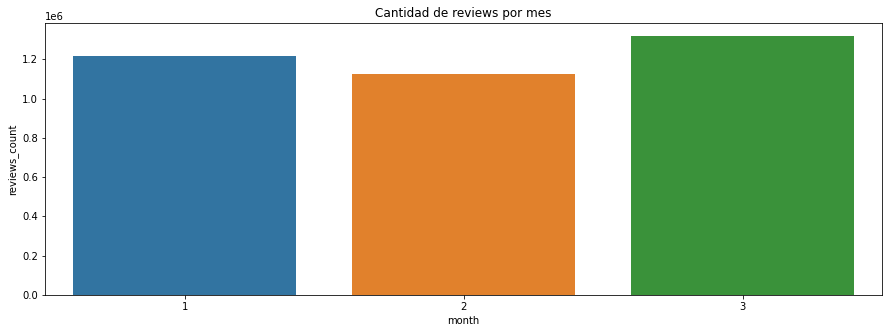

In [75]:
plt.figure(figsize=(15,5))
sns.barplot(x=plot_df.month, y=plot_df.reviews_count)
plt.title("Cantidad de reviews por mes")
plt.show()

Empezamos con el rating

In [80]:
df_train['from'] =  pd.to_datetime(df_train['tunein'], format='%Y-%m-%d %H:%M:%S.%f')

In [81]:
df_train['to'] =  pd.to_datetime(df_train['tuneout'], format='%Y-%m-%d %H:%M:%S.%f')

In [82]:
df_train['resultado'] = df_train['to']-df_train['from']
df_train.head()

,customer_id,account_id,asset_id,tunein,tuneout,timestamp,minutos,from,to,resultado
0,0,90627,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,2021-02-18,43.0,2021-02-18 22:52:00,2021-02-18 23:35:00,0 days 00:43:00
1,0,90627,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,2021-03-24,44.0,2021-03-24 23:17:00,2021-03-25 00:01:00,0 days 00:44:00
2,1,3387,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,2021-03-15,18.0,2021-03-15 10:05:00,2021-03-15 10:23:00,0 days 00:18:00
3,1,3387,895.0,2021-03-15 10:23:00.0,2021-03-15 11:18:00.0,2021-03-15,55.0,2021-03-15 10:23:00,2021-03-15 11:18:00,0 days 00:55:00
4,1,3387,26062.0,2021-03-16 09:24:00.0,2021-03-16 09:44:00.0,2021-03-16,20.0,2021-03-16 09:24:00,2021-03-16 09:44:00,0 days 00:20:00


In [59]:
# Minutos vistos por el usuario
df_train['minutos'] = df_train['resultado'].dt.seconds.div(60).astype(float) 
df_train.head()

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume,timestamp,from,to,resultado,minutos
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,0,2021-02-18 22:52:00,2021-02-18 22:52:00,2021-02-18 23:35:00,0 days 00:43:00,43.0
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,0,2021-03-24 23:17:00,2021-03-24 23:17:00,2021-03-25 00:01:00,0 days 00:44:00,44.0
2,1,3387,STB,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,0,2021-03-15 10:05:00,2021-03-15 10:05:00,2021-03-15 10:23:00,0 days 00:18:00,18.0
3,1,3387,STB,895.0,2021-03-15 10:23:00.0,2021-03-15 11:18:00.0,1,2021-03-15 10:23:00,2021-03-15 10:23:00,2021-03-15 11:18:00,0 days 00:55:00,55.0
4,1,3387,STB,26062.0,2021-03-16 09:24:00.0,2021-03-16 09:44:00.0,0,2021-03-16 09:24:00,2021-03-16 09:24:00,2021-03-16 09:44:00,0 days 00:20:00,20.0


In [76]:
# Esta columna contiene la duración de la pelicula
df_metadatos['run_time_min']

0         48.0
1        105.0
2         82.0
3         99.0
4        126.0
         ...  
33139     64.0
33140     56.0
33141     24.0
33142     42.0
33143     11.0
Name: run_time_min, Length: 33144, dtype: float64

In [77]:
# duración minima
df_metadatos['run_time_min'].min()

0.0

In [78]:
# duracion máxima
df_metadatos['run_time_min'].max()

308.0

Dropeamos lo que no nos sirve

In [83]:
df_train.drop(['device_type','resume','from','to','resultado'],axis=1, inplace=True)

KeyError: ignored

In [84]:
df_metadatos_mini = df_metadatos[['asset_id', 'content_id','title','run_time_min','start_vod_date','end_vod_date']].copy()

Mergeamos los dos datasets a partir del campo asset_id

In [85]:
df_map = df_train.merge(df_metadatos_mini, how="left", left_on="asset_id", right_on="asset_id")
df_map.head()

,customer_id,account_id,asset_id,tunein,tuneout,timestamp,minutos,from,to,resultado,content_id,title,run_time_min,start_vod_date,end_vod_date
0,0,90627,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,2021-02-18,43.0,2021-02-18 22:52:00,2021-02-18 23:35:00,0 days 00:43:00,2040.0,T:5 Ep:08 This is Us,43.0,2021-02-18T00:00:00.0Z,2021-06-30T23:59:59.0Z
1,0,90627,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,2021-03-24,44.0,2021-03-24 23:17:00,2021-03-25 00:01:00,0 days 00:44:00,2040.0,T:5 Ep:10 This is Us,42.0,2021-03-18T00:00:00.0Z,2021-06-30T23:59:59.0Z
2,1,3387,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,2021-03-15,18.0,2021-03-15 10:05:00,2021-03-15 10:23:00,0 days 00:18:00,1983.0,T:1 Ep:02 Big Little Lies,54.0,2021-03-08T00:00:00.0Z,2021-03-28T23:59:00.0Z
3,1,3387,895.0,2021-03-15 10:23:00.0,2021-03-15 11:18:00.0,2021-03-15,55.0,2021-03-15 10:23:00,2021-03-15 11:18:00,0 days 00:55:00,1983.0,T:1 Ep:02 Big Little Lies,54.0,2021-03-08T00:00:00.0Z,2021-03-28T23:59:00.0Z
4,1,3387,26062.0,2021-03-16 09:24:00.0,2021-03-16 09:44:00.0,2021-03-16,20.0,2021-03-16 09:24:00,2021-03-16 09:44:00,0 days 00:20:00,729.0,T:1 Ep:02 Dime quién soy,49.0,2021-03-08T00:00:00.0Z,2021-03-28T23:59:00.0Z


In [86]:
df_map['minutos_vistos'] = df_map['run_time_min'] - df_map['minutos']

In [88]:
df_map['porcentaje_visto'] = df_map['minutos'] * 100 / df_map['run_time_min']


In [89]:
df_map[df_map['minutos_vistos'] < 0].count()[1]

535905

In [90]:
df_map[df_map['minutos_vistos'] < 0].count()[1] * 100 / df_map.shape[0]

14.651015733223321

Creando el rating

In [91]:
df_map['rating'] = df_map['porcentaje_visto'].apply(lambda x : 1 if x >= 50 else 0)
df_map.head()

,customer_id,account_id,asset_id,tunein,tuneout,timestamp,minutos,from,to,resultado,content_id,title,run_time_min,start_vod_date,end_vod_date,minutos_vistos,porcentaje_visto,rating
0,0,90627,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,2021-02-18,43.0,2021-02-18 22:52:00,2021-02-18 23:35:00,0 days 00:43:00,2040.0,T:5 Ep:08 This is Us,43.0,2021-02-18T00:00:00.0Z,2021-06-30T23:59:59.0Z,0.0,100.000000,1
1,0,90627,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,2021-03-24,44.0,2021-03-24 23:17:00,2021-03-25 00:01:00,0 days 00:44:00,2040.0,T:5 Ep:10 This is Us,42.0,2021-03-18T00:00:00.0Z,2021-06-30T23:59:59.0Z,-2.0,104.761905,1
2,1,3387,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,2021-03-15,18.0,2021-03-15 10:05:00,2021-03-15 10:23:00,0 days 00:18:00,1983.0,T:1 Ep:02 Big Little Lies,54.0,2021-03-08T00:00:00.0Z,2021-03-28T23:59:00.0Z,36.0,33.333333,0
3,1,3387,895.0,2021-03-15 10:23:00.0,2021-03-15 11:18:00.0,2021-03-15,55.0,2021-03-15 10:23:00,2021-03-15 11:18:00,0 days 00:55:00,1983.0,T:1 Ep:02 Big Little Lies,54.0,2021-03-08T00:00:00.0Z,2021-03-28T23:59:00.0Z,-1.0,101.851852,1
4,1,3387,26062.0,2021-03-16 09:24:00.0,2021-03-16 09:44:00.0,2021-03-16,20.0,2021-03-16 09:24:00,2021-03-16 09:44:00,0 days 00:20:00,729.0,T:1 Ep:02 Dime quién soy,49.0,2021-03-08T00:00:00.0Z,2021-03-28T23:59:00.0Z,29.0,40.816327,0


Train y Test

In [103]:
ratings = df_map.copy()
ratings.head()

,customer_id,account_id,asset_id,tunein,tuneout,timestamp,minutos,from,to,resultado,content_id,title,run_time_min,start_vod_date,end_vod_date,minutos_vistos,porcentaje_visto,rating
0,0,90627,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,2021-02-18,43.0,2021-02-18 22:52:00,2021-02-18 23:35:00,0 days 00:43:00,2040.0,T:5 Ep:08 This is Us,43.0,2021-02-18T00:00:00.0Z,2021-06-30T23:59:59.0Z,0.0,100.000000,1
1,0,90627,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,2021-03-24,44.0,2021-03-24 23:17:00,2021-03-25 00:01:00,0 days 00:44:00,2040.0,T:5 Ep:10 This is Us,42.0,2021-03-18T00:00:00.0Z,2021-06-30T23:59:59.0Z,-2.0,104.761905,1
2,1,3387,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,2021-03-15,18.0,2021-03-15 10:05:00,2021-03-15 10:23:00,0 days 00:18:00,1983.0,T:1 Ep:02 Big Little Lies,54.0,2021-03-08T00:00:00.0Z,2021-03-28T23:59:00.0Z,36.0,33.333333,0
3,1,3387,895.0,2021-03-15 10:23:00.0,2021-03-15 11:18:00.0,2021-03-15,55.0,2021-03-15 10:23:00,2021-03-15 11:18:00,0 days 00:55:00,1983.0,T:1 Ep:02 Big Little Lies,54.0,2021-03-08T00:00:00.0Z,2021-03-28T23:59:00.0Z,-1.0,101.851852,1
4,1,3387,26062.0,2021-03-16 09:24:00.0,2021-03-16 09:44:00.0,2021-03-16,20.0,2021-03-16 09:24:00,2021-03-16 09:44:00,0 days 00:20:00,729.0,T:1 Ep:02 Dime quién soy,49.0,2021-03-08T00:00:00.0Z,2021-03-28T23:59:00.0Z,29.0,40.816327,0


In [105]:
ratings.drop(['customer_id','asset_id','tunein','tuneout','minutos','from','to','resultado','title', 'run_time_min', 'start_vod_date', 'end_vod_date', 'minutos_vistos', 'porcentaje_visto'],axis=1, inplace=True)
ratings.head()

,account_id,timestamp,content_id,rating
0,90627,2021-02-18,2040.0,1
1,90627,2021-03-24,2040.0,1
2,3387,2021-03-15,1983.0,0
3,3387,2021-03-15,1983.0,1
4,3387,2021-03-16,729.0,0


In [106]:
ratings = ratings[['account_id', 'content_id', 'rating', 'timestamp']]

In [107]:
train = ratings[(ratings.timestamp >= datetime(year=2021, month=1, day=1)) &
                (ratings.timestamp < datetime(year=2021, month=3, day=1))]
train.head()

,account_id,content_id,rating,timestamp
0,90627,2040.0,1,2021-02-18
6,3388,2100.0,0,2021-01-01
7,3388,2100.0,0,2021-01-02
8,3388,2100.0,0,2021-01-02
9,3388,2100.0,0,2021-01-04


In [108]:
train.shape

(2339064, 4)

In [110]:
train.account_id.nunique()

99649

In [111]:
test = ratings[ratings.timestamp >= datetime(year=2021, month=3, day=1)]
test.head()

,account_id,content_id,rating,timestamp
1,90627,2040.0,1,2021-03-24
2,3387,1983.0,0,2021-03-15
3,3387,1983.0,1,2021-03-15
4,3387,729.0,0,2021-03-16
5,3387,729.0,0,2021-03-16


In [112]:
test.shape

(1318737, 4)

In [113]:
test.account_id.nunique()

87635

¿Tenemos usuarios que aparecen en test pero no en train? 

In [114]:
test[~test.account_id.isin(train.account_id.unique())].account_id.nunique()

14232

Como vemos, tenemos este problema. Utilizaremos "cold start" al momento de recomendar a estos usuarios.

Armamos la matriz de interacción.

In [115]:
matrix_columns = ["account_id","content_id", "rating"]

In [116]:
interactions = train[matrix_columns]
interactions.head()

,account_id,content_id,rating
0,90627,2040.0,1
6,3388,2100.0,0
7,3388,2100.0,0
8,3388,2100.0,0
9,3388,2100.0,0


In [ ]:
# interactions_matrix = pd.pivot(index="account_id", columns="content_id", values="rating")
interactions_matrix = pd.pivot_table(interactions[["account_id","content_id", "rating"]], index='account_id', columns='content_id', values='rating')
interactions_matrix.head()

Completo los NaN con ceros

In [1]:
interactions_matrix = interactions_matrix.fillna(0)
interactions_matrix.head()

NameError: ignored

¿Cuántas filas y columnas tiene la matriz de interacción?

In [ ]:
interactions_matrix.shape

Generemos diccionarios de usuarios y items

In [ ]:
user_id = list(interactions_matrix.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1

In [ ]:
item_id = list(interactions_matrix.columns)
item_dict = {}
counter = 0 
for i in item_id:
    item_dict[i] = counter
    counter += 1

Transformamos la matriz a csr matrix (compressed sparse row)

In [ ]:
interactions_matrix_csr = csr_matrix(interactions_matrix.values)

# Modelo

Utilizaremos la librería LFM (light fm) para realizar un modelo de recomendación.

In [ ]:
model = LightFM(no_components=3, random_state=100, learning_rate=0.03)

Entrenar el modelo con la matriz csr por 10 epochs:

In [ ]:
model = model.fit(interactions_matrix_csr, epochs=10)